#### Upload functions

In [1]:
from bb2022_functions import *
%matplotlib inline
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio import SeqIO
pd.options.mode.chained_assignment = None  # default='warn'

## Import and format metadata from lab, and BBMP

In [2]:
md = pd.read_csv("metadata_merged.csv")
merged = pd.read_csv("metadata_niskin.csv")
all_md = pd.read_csv("allmetadata.csv")

In [ ]:
detect_anomalies('Temperature_y', all_md, 1, yr={2022}, month={1,2,3,4,5})

In [ ]:
d1 = all_md.loc[all_md['depth'] == 1]
d1 = d1[['weekn', 'depth', 'Phosphate',
       'Ammonia', 'Chlorophyll A']]
d1.rename(columns={'Temperature_x': 'Temperature'},
          inplace= True)

In [ ]:
d1 = d1.melt(id_vars=['weekn', 'depth'])

In [ ]:
def get_stage(weekNb):
    if weekNb <8:
        return 'Pre-bloom'
    elif weekNb >= 8:
        return 'Bloom'

d1['Time'] = d1['weekn'].apply(get_stage)

In [ ]:
df1 = d1[d1['Time'] == 'Bloom']
df2 = d1[d1['Time'] == 'Pre-bloom']

In [ ]:
sns.lmplot(
    data = d1,
    x="weekn", y="value",
    hue = 'variable', palette = 'viridis', scatter=True
)

In [ ]:
sns.lmplot(x='weekn', y='value', data=df1, hue='variable') 
sns.lmplot(x='weekn', y='value', data=df2, hue='variable')

In [ ]:
d1 = all_md.loc[all_md['depth'] == 1]
d1 = d1[['weekn', 'Temperature_x']]
d1.rename(columns={'Temperature_x': 'Temperature'},
          inplace= True)

In [ ]:
d1.drop_duplicates(inplace=True)
d1.set_index('weekn', inplace=True)

In [ ]:
rolling_mean = d1.rolling(5).mean()
rolling_std = d1.rolling(5).std()

In [ ]:
plt.plot(d1, color="blue",label="Temperature")
plt.plot(rolling_mean, color="red", label="Rolling Mean Temperature")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation Temperate")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
#plt.legend(loc="upper right")

In [ ]:
autocorrelation_lag1 = d1['Temperature'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = d1['Temperature'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = d1['Temperature'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = d1['Temperature'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
decompose = seasonal_decompose(d1['Temperature'],model='multiplicative', period=3)
trend = decompose.trend
residual = decompose.resid

decompose.plot();
plt.show()

In [ ]:
sns.relplot(
    data=d1, x="weekn", y="value",
    row="depth", hue="variable",
    kind="line"
)

## Add prokaryotic community

Data prep

In [3]:
#generate a dataframe from all specified amplicon
df, comm = consolidate_tables('16S')
merged = merge_metadata(df, all_md)
separated = pick_metadata(merged)

Found all 16S tables.
Successfully saved all tables.
Set up metadata ...
Saved merged_asvs_metadata.tsv
Appended all taxonomies to taxos
Saved separated by metadata dataframe.


Remove chloroplast, cyanobacteria

In [4]:
searchfor = ["Cyanobacteria", "Chloroplast"]
contaminants = separated[separated.Taxon.str.contains('|'.join(searchfor))]
separated = separated[~separated.Taxon.str.contains('|'.join(searchfor))]
separated = separated.reset_index(drop=True)

In [ ]:
#run these lines to switch to chloroplast comm
separated = contaminants.copy()
separated = separated.reset_index(drop=True)
comm = 'chloroplast'

#add phytorep taxonomy
cp_tax = pd.read_csv('chloroplast/taxonomy.tsv', sep='\t')
cp_tax = cp_tax.rename(columns={"Feature ID": "feature_id", "Taxon": "PRTaxon", "Confidence":"PRConfidence"})
separated = pd.merge(separated, cp_tax, on="feature_id", how="left")
separated['PRSpecies'] = separated['PRTaxon'].str.split('|').str[-1]

In [5]:
#re-calculate ratios when removing chloroplast for 16S
separated['Total'] = separated['feature_frequency'].groupby(separated['sampleid']).transform('sum')
separated['ratio'] = separated['feature_frequency']/separated['Total']
separated['nASVs'] = separated['feature_id'].groupby(separated['sampleid']).transform('count')
separated['weekdepth'] = separated["weekn"].astype(str) + separated["depth"].astype(str)
separated['avg'] = separated['nASVs'].groupby(separated['weekdepth']).transform('mean')
separated['diff'] = separated['nASVs'] - separated['avg']

Run the following code to generate "newseparated" which is the union of small and large size fractions

In [6]:
newseparated = make_defract(all_md, separated)
newseparated["rank"] = newseparated.groupby("sampleid")["ratio"].rank(method="average", ascending=False)
newseparated["ranktot"] = newseparated['rank'] / newseparated['nASVs']

/Users/Diana/Documents/escuela/phd/size_fractions/bb2022_functions.py:2031: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  tohm = linreg.pivot("depth", "size_code", "slope")


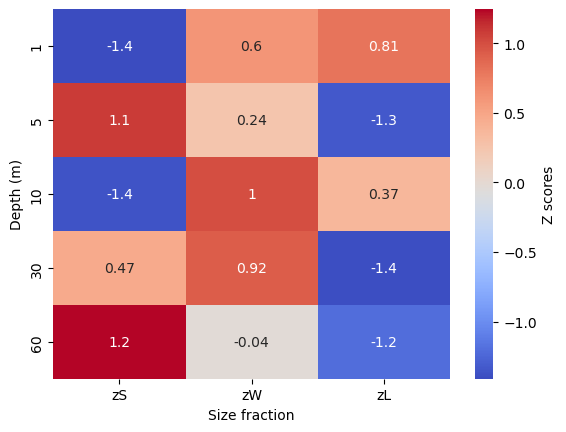

In [7]:
tohm, z_sc_df = get_slopes(comm, separated)
#a zscore of 1= 1 std away from the mean,
#positive values=higher than mean, neg= smaller than mean

In [ ]:
sns.lineplot(data=newseparated, x="depth", y="nASVs", hue='size_code')

In [ ]:
grab_80perc(comm, newseparated, 0.95, 'feature_id')

In [ ]:
depth_num = {
    "A": 1,
    "B": 5,
    "C": 10,
    "D": 60,
    "E": 30
}

df_Grouped.columns = df_Grouped.columns.droplevel()
df_Grouped['Topn80'] = df_Grouped['Topn80']+1

df_Grouped.rename(columns={'' :'sampleid'}, inplace=True)
df_Grouped["size_code"] = df_Grouped["sampleid"].str.extract(r'[1-9][0-9]?[A-E](SL|[L-S])')
df_Grouped["size_code"] = df_Grouped["size_code"].fillna('W')
df_Grouped["depth_code"] = df_Grouped["sampleid"].str.extract(r'[1-9][0-9]?([A-E])')
df_Grouped['depth']= df_Grouped['depth_code'].map(depth_num)
df_Grouped["weekn"] = df_Grouped["sampleid"].str.extract(r'\.([1-9][0-9]?)[A-E]')
df_Grouped['weekn'] = pd.to_numeric(df_Grouped['weekn'])
df_Grouped['depth'] = pd.to_numeric(df_Grouped['depth'])

In [ ]:
for depth in depths:
    df_1 = df5[df5.depth == depth]
    sns.barplot(df_1, x="weekn", y="lengthtotal", hue="size_code")
    plt.savefig('outputs/'+comm+'/nASVintop'+str(depth)+'_RL_'+SFX+SFY+'.png', dpi=200, bbox_inches="tight")

In [ ]:
sns.barplot(df_1, x="weekn", y="Topn80", hue="size_code")

In [ ]:
separated = separated[separated.size_code != 'S']
#separated = separated[separated.size_code != 'S']

In [ ]:
#to import for weighted unifrac
to_biom = onlyDFRW[['sampleid', 'feature_id', 'feature_frequency']].copy().drop_duplicates()
to_biom = to_biom.pivot(index='sampleid', columns='feature_id', values='feature_frequency').fillna(0)
to_biom.to_csv('newbiom'+comm+'.tsv', sep='\t')

In [ ]:
table=onlyDFRW

In [ ]:
#loglog plot
depths = [1,5,10,30,60]
table = newseparated

for depth in depths:
    pca, pca_features, sfdclr, distance_matrix = pcaplot(table, depth, comm, 'size_code', 'DFr', 'week')
    distance_matrix2 = distance_matrix.reset_index()
    idedup = distance_matrix2['samples'].to_list()
    dm = DistanceMatrix(distance_matrix, ids=idedup)
    df123 = dm.to_data_frame()
    df123.to_csv('outputs/'+comm+'/distance_matrix_d'+str(depth)+'.tsv', sep='\t')

In [ ]:
upsetprep(comm, 'feature_id', separated)

In [ ]:
pca, pca_features, sfdclr, distance_matrix = pcaplot(newseparated, 1, comm, 'size_code', 'DFr', 'week')

In [ ]:
pca_features

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def get_correlated_dataset(n, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

fig, ax_nstd = plt.subplots(figsize=(6, 6))

In [ ]:
dependency_nstd = [[0.8, 0.75],
                   [-0.2, 0.35]]
mu = 0, 0
scale = 8, 5

In [ ]:
ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

In [ ]:
x, y = get_correlated_dataset(500, dependency_nstd, mu, scale)
ax_nstd.scatter(x, y, s=0.5)

In [ ]:
confidence_ellipse(x, y, ax_nstd, n_std=1,
                   label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2,
                   label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(x, y, ax_nstd, n_std=3,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':')

ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Different standard deviations')
ax_nstd.legend()
plt.show()

In [ ]:
confidence_ellipse(x, y, ax_nstd, n_std=1,
                   label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2,
                   label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(x, y, ax_nstd, n_std=3,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':')

In [ ]:
ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Different standard deviations')
ax_nstd.legend()
plt.show()

In [ ]:
newseparated.drop_duplicates(inplace=True)

In [ ]:
depth=1
level = 'Genus'
table = newseparated
sfd=table[table.depth==depth]
toptaxa = sfd[['feature_frequency', 'ratio', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code',level, 'weekn']).agg({'ratio':sum})
topd = df_agg['ratio'].groupby(['size_code', 'weekn'], group_keys=False).nlargest(4)
topd = topd.to_frame()
topd = topd.reset_index()

taxonomy = table[[level, 'Taxon']].copy()
taxonomy.drop_duplicates(inplace=True)

tosave = pd.merge(topd, taxonomy, how ='inner', on=level)
tosave.sort_values(['weekn', 'size_code']).to_csv(str(depth)+comm+'top3.csv')

tosave=tosave.sort_values(['weekn', 'size_code'])

tosave['weekfid'] = tosave["weekn"].astype(str) + tosave["size_code"].astype(str)

In [ ]:
fig = px.bar(tosave, x="size_code", y="ratio", facet_col="weekn", color=level, labels={
                     "ratio": "Relative abundance",
                     "size_code": "",
                     "weekn": "w"}, hover_data=["Taxon"], width=950, height=1000)

fig.update_xaxes(type='category', dtick=1)
fig.update_layout(
    #title= text="Relative abundance of top"+str(topn) + level + 'observed at Depth' + str(depth),
    yaxis_title="Relative abundance",
    xaxis_title="Size fraction",
    legend_title=level,
    font=dict(size=8),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-1,
        xanchor="right",
        x=1
    )
)

fig.show()

In [ ]:
topiv = tosave[['feature_id', 'ratio', 'weekfid']].copy()
topiv = topiv.drop_duplicates()

In [ ]:
original_order = topiv["weekfid"].unique()

In [ ]:
sfdpiv= topiv.pivot(index='weekfid', columns='feature_id', values='ratio').reindex(index=original_order)

In [ ]:
sfdpiv=sfdpiv.fillna(0)
sfdclr=sfdpiv.mask(sfdpiv==0).fillna(0.1)
clr_transformed_array = clr(sfdclr)
samples = sfdpiv.index
asvs = sfdpiv.columns

In [ ]:
#Creating the dataframe with the clr transformed data, and assigning the sample names
clr_transformed = pd.DataFrame(clr_transformed_array, columns=asvs)
#Assigning the asv names
clr_transformed['samples'] = samples
clr_transformed = clr_transformed.set_index('samples')
clr_transformed.head()

#calculate distance matrix
dist = cdist(clr_transformed, clr_transformed, 'euclid')
distance_matrix = pd.DataFrame(dist, columns=samples)
distance_matrix['samples'] = samples
distance_matrix = distance_matrix.set_index('samples')

In [ ]:
fig = px.imshow(distance_matrix)
fig.show()

In [ ]:
df

In [ ]:
comm

In [ ]:
pca, pca_features, sfdclr, distance_matrix = pcaplot(newseparated, 'all', comm, 'size_code', 'DFr', 'week')

In [ ]:
#df=newseparated[newseparated.depth==1]
df=newseparated.copy()

In [ ]:
topiv = df[['feature_id', 'feature_frequency', 'sampleid']].copy()
topiv = topiv.drop_duplicates()

sfdpiv= topiv.pivot(index='sampleid', columns='feature_id', values='feature_frequency')
sfdpiv=sfdpiv.fillna(0)
sfdclr=sfdpiv.mask(sfdpiv==0).fillna(0.1)
clr_transformed_array = clr(sfdclr)
samples = sfdpiv.index
asvs = sfdpiv.columns

In [ ]:
plot_df = pd.DataFrame(data = pca_features, columns = ['dim1', 'dim2'], index = sfdpiv.index)
plot_df['dim1'] = plot_df['dim1']/1000
plot_df['dim2'] = plot_df['dim2']/1000
plot_df2 = pd.merge(plot_df,df[['sampleid','size_code','depth', 'weekn']],on='sampleid', how='left')

In [ ]:
def get_stage(weekNb):
    if weekNb < 8:
        return 'Pre-bloom'
    elif weekNb >= 8:
        return 'Bloom'

if depth != 'all':
    plot_df2['Time'] = plot_df2['weekn'].apply(get_stage)

In [ ]:
plot_df2.to_csv('R_results/R_testing_vis/for_R.csv')

In [ ]:
import plotly.express as px

fig = px.scatter(plot_df2, x="dim1", y="dim2", color='size_code', symbol="depth",
                hover_data=['weekn', 'depth'])
fig.show()

### Write out fasta file of chloroplast/cyano sequences

In [ ]:
fa = SeqIO.parse('chloroplast/dna-sequences.fasta' ,
                 "fasta")
seqs_i_want = [] #we'll put the good sequences here
fid_chloro = newseparated['feature_id'].unique()
for record in fa: #a SeqRecord has the accession as record.id, usually.
    if record.id in fid_chloro: #This is how you check if the accession is in the values of the dict
        seqs_i_want.append(record)
#Now we can write the list of records to a fasta file. This will take care of the formatting etc
with open('chloroplast/selected_dna.fasta', "w") as f:
    SeqIO.write(seqs_i_want, f, "fasta")

### Richness analysis

In [ ]:
sfd1 = newseparated[['sampleid','size_code', 'weekn', 'nASVs', 'depth']].copy()

In [ ]:
#group the dataframe with all features to obtain either the mean or std of number of features per size fraction
sfd1.groupby(['size_code']).mean()

In [ ]:
comm

In [ ]:
sfd1.describe()

In [ ]:
#run the visualisations for alpha diversity and run pairwise t-tests between size fractions for richness values
anova, results = boxplot_depth(separated, comm, 5, 'nASVs', 'Number of ASVs')

In [ ]:
results

In [ ]:
roll_avg(comm, newseparated, 1, 'nASVs',4)

In [ ]:
df= newseparated[['sampleid', 'weekn','depth', 'size_code', 'nASVs']].copy()

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df

## Simple regression analysis between pairs of size fractions

How to detect outliers?

In [ ]:
newseparated.loc[(newseparated['ratio'] > 0.25)].sort_values('ratio')

In [ ]:
q75, q25 = np.percentile(slwplot['L'], [75 ,25])
iqr = q75 - q25

In [ ]:
newslw = outlier(slwplot)

In [ ]:
newslw['L'].isna().sum()

In [ ]:
comm

Run RL

In [ ]:
df_results = SRA_pairs(comm, 'W', 'SL', newseparated, outliers='None', view=False)

In [ ]:
df_results

investigate temporal pattern thorugh all depths of outliers

In [ ]:
supsel = newseparated.loc[newseparated['feature_id'] == '75ceeaa937c64399438614ca3706cf2a'].sort_values('feature_frequency')
supsel['depth'].unique()

In [ ]:
sns.scatterplot(data = supsel, x = 'weekn', y = 'ratio', hue='depth')

In [ ]:
#draw interactive plotly to identify outliers
depth=1
X='W'
Y='L'

d1 = newseparated.loc[newseparated['depth'] == depth]
forpl = d1[['ratio', 'feature_id', 'sampleid', 'weekn', 'depth', 'size_code', 'Phylum', 'Family']].copy()
slwplot = forpl.pivot_table(index=["feature_id", "depth", 'weekn','Phylum', 'Family'], columns="size_code", values='ratio').fillna(0)
slwplot = slwplot.reset_index()
fig = px.scatter(slwplot, x=X, y=Y, color="weekn", trendline="ols")
fig.show()

results = px.get_trendline_results(fig)
print(results)

#results.query("weekn ==  and Phylum == ").px_fit_results.iloc[0].summary()

### Plot all r^2 values

In [ ]:
r2vals = pd.read_csv("R_results/RL_results_ALL.csv")

In [ ]:
sns.set_theme(rc={'figure.figsize':(5,4)})
sns.set_style("ticks")
sns.boxplot(data=r2vals, x="Y", y="Rsq", hue="Marker Gene")
plt.ylabel('R-squared', fontsize=12)
plt.xlabel('Size fraction against total', fontsize=12)

plt.savefig('outputs/'+'_rsq_both.png', dpi=200, bbox_inches="tight")

### Calculate log2 fold change per feature at the phylum level of abundance between size fractions to identify which taxonomic group is driving the simple regression off x=y

In [ ]:
#add pseudo count for log-calculations and zero divisions
slwplot['SL'] = slwplot['SL'] + 0.0000001
slwplot['W'] = slwplot['W'] + 0.0000001

#calculate log2 fold change
slwplot['OR'] = (slwplot['W'] - slwplot['SL']) / slwplot['SL']
slwplot['fold_change'] = slwplot['W']/slwplot['SL']
slwplot['log2_fold_change'] = np.log2(slwplot['fold_change'])

In [ ]:
#make dual plot of log2FC and mean relative abundances side by side including error bars in the plots
data = slwplot[['log2_fold_change','Phylum', 'W', 'SL']].copy()

data['Phylum'] = data['Phylum'].map(lambda x: x.lstrip('p__'))

# Group by index labels and take the means and standard deviations for each group
data['avg_W'] = data['W'].groupby(data['Phylum']).transform('mean')
data['std_W'] = data['W'].groupby(data['Phylum']).transform('std')
data['avg_SL'] = data['SL'].groupby(data['Phylum']).transform('mean')
data['std_SL'] = data['SL'].groupby(data['Phylum']).transform('std')
data['means'] = data['log2_fold_change'].groupby(data['Phylum']).transform('mean')
data['stds'] = data['log2_fold_change'].groupby(data['Phylum']).transform('std')

data['positive'] = data['means'] > 0

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8, 10))

axes[0].barh(data['Phylum'], data['means'],
         xerr = data['stds'],
         error_kw=dict(lw=0.5, capsize=1, capthick=0.5),
         color=data.positive.map({True: 'g', False: 'r'}))

axes[1].barh(data['Phylum'], data['avg_W'],
            xerr = data['std_W'],
         error_kw=dict(lw=0.5, capsize=1, capthick=0.5))

#axes[2].barh(data['Phylum'], data['avg_SL'],
#            xerr = data['std_SL'],
#         error_kw=dict(lw=0.5, capsize=1, capthick=0.5))

plt.gca().invert_yaxis()


plt.savefig('outputs/'+comm_id+'/log2foldchange_d'+str(depth)+'.png', bbox_inches='tight', dpi=300)

#plt.show()

In [ ]:
#bar plot of log2FC per phylum without error bars
data = slwplot[['log2_fold_change','Phylum']].copy()
data['Phylum'] = data['Phylum'].map(lambda x: x.lstrip('p__'))

# Group by index labels and take the means and standard deviations for each group
#data['means'] = data['log2_fold_change'].groupby(data['Phylum']).transform('mean')
#data['stds'] = data['log2_fold_change'].groupby(data['Phylum']).transform('std')

data['positive'] = data['log2_fold_change'] > 0

plt.figure(figsize=(6,11))
plt.barh(data['Phylum'], data['log2_fold_change'],
         color=data.positive.map({True: 'g', False: 'r'}))
plt.gca().invert_yaxis()

plt.savefig('outputs/'+comm_id+'/log2foldchange_d'+str(depth)+'_noerr.png', bbox_inches='tight', dpi=300)

#plt.show()

In [ ]:
not_in_W = slwplot.loc[slwplot['W'] == 0]
#not_in_W['feature_id'].nunique()
not_in_W_from_S = not_in_W.loc[not_in_W['L'] == 0]
#not_in_W_from_S['feature_id'].nunique()

#calculate the percentage of features coming from the small size fraction that are absent from the whole  
not_in_W_from_S['feature_id'].nunique()/not_in_W['feature_id'].nunique()

In [ ]:
sns.scatterplot(data=not_in_W, x='S', y='SL', hue='weekn')

### run lmplot for each pair of sets

In [ ]:
#loglog plot
depths = [1,5,10,30,60]

for depth in depths:
    d1 = newseparated.loc[newseparated['depth'] == depth]
    forpl = d1[['ratio', 'feature_id', 'sampleid', 'weekn', 'depth', 'size_code', 'Phylum']].copy()
    slwplot = forpl.pivot_table(index=["feature_id", "depth", 'weekn', 'Phylum'], columns="size_code", values='ratio').fillna(0)
    slwplot = slwplot.reset_index()
    sns.set_style("white")

    #slwplot = slwplot.loc[slwplot['weekn'] = 10]
    #slwplot = slwplot.loc[slwplot['weekn'] = 11]

    slwplot = slwplot.rename(columns={"depth": "Depth"})
    slwplot["weekn"] = pd.to_numeric(slwplot["weekn"])
    g = sns.scatterplot(x="W", y="SL", data=slwplot, palette=['black'])#, hue='Phylum', alpha=0.6) #, hue="weekn");
    
    #uncomment for log-log
    #ax.set(xscale="log", yscale="log")
    g.set_ylabel("Defractionated",fontsize=15)
    g.set_xlabel("Unfractionated",fontsize=15)
    g.tick_params(labelsize=12)
    #g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=3)
    plt.legend([],[], frameon=False)
    
    #plt.savefig('outputs/lmplot_'+comm+str(depth)+'WSL.png', bbox_inches='tight', dpi=300)

    plt.show()

### Phylogenetic analysis: taxonomic bar plots of relative abundance per depth and size fraction

In [ ]:
if comm == 'chloroplast':
    level = 'PRTaxon'
else:
    level = 'Genus'
    
table = newseparated
#get a list of top taxa to provide the palette for the visualisation
toptaxa = table[['feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code',level, 'depth']).agg({'feature_frequency':sum})
topd = df_agg['feature_frequency'].groupby(['size_code', 'depth'], group_keys=False).nlargest(3)
topd = topd.to_frame()
topd = topd.reset_index()
listoftop = topd[level].unique()

#set a palette for the toptaxa
hex_colors_dic = {}
rgb_colors_dic = {}
hex_colors_only = []
for name, hex in matplotlib.colors.cnames.items():
    hex_colors_only.append(hex)
    hex_colors_dic[name] = hex
    rgb_colors_dic[name] = matplotlib.colors.to_rgb(hex)
    
palette_dict = {taxon: color for taxon, color in zip(listoftop, px.colors.sequential.Plasma)}

In [ ]:
phyld, top10d = taxbarplot(table, level, 1, 3, palette_dict, 'size_code')

In [ ]:
phyld.to_csv('feature_id_proks_1m_top3.csv')

In [ ]:
import plotly.io as pio
pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'

#### Top taxon longitudinal analysis

In [ ]:
sfd=newseparated
if comm == 'chloroplast':
    level = 'PRSpecies'
else:
    level = 'Genus'
toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn']].copy()
toptaxa = toptaxa.drop_duplicates()

In [ ]:
toptaxa['Genus'] = toptaxa['Taxon'].str.split('s__').str[0]

In [ ]:
sfd=newseparated
if comm == 'chloroplast':
    level = 'PRSpecies'
else:
    level = 'Genus'
toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
toptaxa = toptaxa.drop_duplicates()

In [ ]:
df_agg = toptaxa.groupby(['size_code',level, 'depth', 'weekn']).agg({'feature_frequency':sum})
topd = df_agg['feature_frequency'].groupby(['size_code', 'depth','weekn'], group_keys=False).nlargest(1)
topd = topd.to_frame()
topd = topd.reset_index()
topd['Genus'].unique()

#if looking at groups of top
#newdf = topd.groupby(['size_code', 'depth','weekn'])[level].apply(lambda x: list(set(x)))
#newdf = newdf.reset_index()

#result = newdf.copy()

#result = newdf.Genus.sort_values().apply(lambda x: sorted(x))
#result = pd.DataFrame(result).reset_index(drop=True)

#result['liststring'] = result[level].apply(lambda x: ','.join(map(str, x)))
#result['liststring'].unique()

In [ ]:
type_dic={'d__Bacteria; p__Planctomycetota; c__OM190; o__OM190; f__OM190; g__OM190; ':9,
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__Ulvibacter; ':1,
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Salinisphaerales; f__Solimonadaceae; g__Polycyclovorans; ':6,
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Alteromonadales; f__Alteromonadaceae; g__Alteromonas':16,
       'd__Archaea; p__Crenarchaeota; c__Nitrososphaeria; o__Nitrosopumilales; f__Nitrosopumilaceae; g__Candidatus_Nitrosopumilus':15,
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__NS3a_marine_group':10,
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__SAR11_clade; f__Clade_I; g__Clade_Ia':14,
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Sulfitobacter':4,
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__Polaribacter':7,
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Planktomarina':8,
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae; g__SUP05_cluster':3,
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Crocinitomicaceae; g__Fluviicola':12,
       'd__Bacteria; p__Nitrospinota; c__Nitrospinia; o__Nitrospinales; f__Nitrospinaceae; g__LS-NOB':11,
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae':2,
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Alteromonadales; f__Colwelliaceae; g__Colwellia':13,
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas':5}

In [ ]:
Alteromonas
Candidatus_Nitrosopumilus
Clade_Ia
Colwellia
Fluviicola
LS-NOB
NS3a_marine_group
OM190
Planktomarina
Polaribacter
Polycyclovorans
Pseudomonas
Sulfitobacter
SUP05_cluster
Thioglobaceae
Ulvibacter

In [ ]:
type_dic_old = {'g__Alteromonas':1, 'g__Candidatus_Nitrosopumilus':2, 'g__Clade_Ia':3,
       'g__Colwellia':4, 'g__Fluviicola':5, 'g__NS3a_marine_group':6,
       'g__OM190':7, 'g__Planktomarina':8, 'g__Polaribacter':9,
       'g__Polycyclovorans':10, 'g__Pseudomonas':11, 'g__SUP05_cluster':12,
       'g__Sulfitobacter':13, 'g__Ulvibacter':14, 'g__uncultured':15}

In [ ]:
type_dic = {'Unassigned':15, 'g__Alteromonas':14, 'g__Candidatus_Nitrosopumilus':13,
       'g__Clade_Ia':12, 'g__Colwellia':11, 'g__Fluviicola':10,
       'g__NS3a_marine_group':9, 'g__OM190':8, 'g__Planktomarina':7,
       'g__Polaribacter':6, 'g__Polycyclovorans':5, 'g__Pseudomonas':4,
       'g__Sulfitobacter':3, 'g__Ulvibacter':2, 'g__uncultured':1}

In [ ]:
#only if multiple organimsms in top ocmmunity 
result['comm_type'] = ''

for tx, ctype in type_dic.items():
    result.loc[result['liststring'] == tx, 'comm_type'] = ctype
topd = result.copy()

In [ ]:
#list the unique top taxa
topd[level].unique()

In [ ]:
type_dic = {'Teleaulax':1, 'Thalassiosira':2, 'Chaetoceros':3, 'Unassigned':4,
       'Eutreptiella':5, 'Micromonas':6, 'Phaeocystis':7,
       'uncultured+bacterium':8, 'Haptolina':9, 'Chrysochromulina':10}

In [ ]:
type_dic = {
    #"c__Cyanobacteriia": 1,
    "c__OM190": 3,
    "c__Bacteroidia": 2,
    "c__Gammaproteobacteria": 5,
    "c__Alphaproteobacteria": 4}

In [ ]:
topd['comm_type'] = ''

for tx, ctype in type_dic.items():
    topd.loc[topd[level] == tx, 'comm_type'] = ctype

In [ ]:
topd["sc_weekn"] = topd["depth"].astype(str) + topd["size_code"]

In [ ]:
topd = topd.sort_values(['depth', 'size_code'])

In [ ]:
topdlist = topd['sc_weekn'].tolist()

def uniqlist(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

mylist = uniqlist(topdlist)

In [ ]:
glue = topd.pivot(index="sc_weekn", columns="weekn", values="comm_type")
glue = glue.reindex(mylist)
glue = glue[glue.columns].astype(float)

In [ ]:
cmap = plt.get_cmap('tab20', 16)

In [ ]:
sns.set_style('ticks')
plt.figure(figsize=(5, 5))


ax = sns.heatmap(glue, fmt='f', yticklabels=True, linewidths=.5, cmap=cmap)
ax.axhline(4, ls='--')
ax.axhline(8, ls='--')
ax.axhline(12, ls='--')
ax.axhline(16, ls='--')

ax.set_xticks(range(0, 16, 5))

plt.savefig('outputs/'+comm+'/heatmap_top1_16s_genus.png', bbox_inches='tight', dpi=300)

plt.show()

#### Longitudinal analysis of top 1 taxa for eukaryotes (more than 20 groups)

Run these lines only for the 18S rRNA analysis

In [ ]:
sfd=newseparated
if comm == 'chloroplast':
    level = 'PRSpecies'
else:
    level = 'Genus'
toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn']].copy()
toptaxa = toptaxa.drop_duplicates()
toptaxa['Genus'] = toptaxa['Taxon'].str.split('s__').str[0]

In [ ]:
df_agg = toptaxa.groupby(['size_code',level, 'depth', 'weekn']).agg({'feature_frequency':sum})
topd = df_agg['feature_frequency'].groupby(['size_code', 'depth','weekn'], group_keys=False).nlargest(1)
topd = topd.to_frame()
topd = topd.reset_index()
topd['Genus'].unique()

In [ ]:
#18S has many more classes as top values to
top518s = topd['Genus'].value_counts()[:19].index.tolist()

topd.loc[~topd["Genus"].isin(top518s), "Genus"] = "Other"

#if looking at groups of top
newdf = topd.groupby(['size_code', 'depth','weekn'])[level].apply(lambda x: list(set(x)))
newdf = newdf.reset_index()

result = newdf.copy()

result = newdf.Genus.sort_values().apply(lambda x: sorted(x))
result = pd.DataFrame(result).reset_index(drop=True)

result['liststring'] = result[level].apply(lambda x: ','.join(map(str, x)))

result['liststring'].unique()

In [ ]:
Other (Prymnesiales, Thalassiosira, Ploimida, Cydippida, Thecofilosea uncultured, d_Eukaryota,Cyclopoida
      MAST-2, o_Syndiniales, Mitochondria, Choreotrichia uncultured, Amoebophrya, g__Pelagostrobilidium 
       g__Oxytrichidae
       g__Spirotontonia g__MAST-1A g__Cryptocaryon g__Caecitellus g__Capitellida o__Helotiales 
       c__Dothideomycetes
       g__Leptothecata o__Pucciniales p__Prymnesiophyceae g__Haplozoon g__MAST-7A g__Pithites
Unassigned
Bathycoccus
Calanoida
Chaetoceros
Choreotrichia uncultured
Dinophyceae
Filobasidium
Gymnodiniphycidae
Hymenoptera
Magnoliophyta
Oligotrichia
Phaeocystis
Pucciniaceae
Spirotrichea
Strombidium
Syndiniales GroupI
Syndiniales uncultured
Teleaulax
Trachymedusae

In [ ]:
type_dic = {'Other':20, 'Unassigned':19,
       'd__Eukaryota; p__Arthropoda; c__Insecta; o__Hymenoptera; f__Hymenoptera; g__Hymenoptera':11,
       'd__Eukaryota; p__Arthropoda; c__Maxillopoda; o__Calanoida; f__Calanoida; g__Calanoida':17,
       'd__Eukaryota; p__Basidiomycota; c__Pucciniomycetes; o__Pucciniales; f__Pucciniaceae':7,
       'd__Eukaryota; p__Basidiomycota; c__Tremellomycetes; o__Filobasidiales; f__Filobasidiaceae; g__Filobasidium':13,
       'd__Eukaryota; p__Chlorophyta; c__Mamiellophyceae; o__Mamiellales; f__Mamiellales; g__Bathycoccus; ':18,
       'd__Eukaryota; p__Ciliophora; c__Intramacronucleata; o__Spirotrichea':6,
       'd__Eukaryota; p__Ciliophora; c__Intramacronucleata; o__Spirotrichea; f__Choreotrichia; g__uncultured; ':15,
       'd__Eukaryota; p__Ciliophora; c__Intramacronucleata; o__Spirotrichea; f__Oligotrichia':9,
       'd__Eukaryota; p__Ciliophora; c__Intramacronucleata; o__Spirotrichea; f__Oligotrichia; g__Strombidium; ':5,
       'd__Eukaryota; p__Cnidaria; c__Hydrozoa; o__Trachymedusae; f__Trachymedusae; g__Trachymedusae; ':1,
       'd__Eukaryota; p__Cryptophyceae; c__Cryptophyceae; o__Cryptomonadales; f__Cryptomonadales; g__Teleaulax; ':2,
       'd__Eukaryota; p__Diatomea; c__Mediophyceae; o__Mediophyceae; f__Mediophyceae; g__Chaetoceros':16,
       'd__Eukaryota; p__Dinoflagellata; c__Dinophyceae':14,
       'd__Eukaryota; p__Dinoflagellata; c__Dinophyceae; o__Gymnodiniphycidae':12,
       'd__Eukaryota; p__Phragmoplastophyta; c__Embryophyta; o__Magnoliophyta; f__Magnoliophyta; g__Magnoliophyta; ':10,
       'd__Eukaryota; p__Protalveolata; c__Syndiniales; o__Syndiniales; f__Syndiniales; g__uncultured; ':3,
       'd__Eukaryota; p__Protalveolata; c__Syndiniales; o__Syndiniales; f__Syndiniales_Group_I; g__Syndiniales_Group_I; ':4,
       'd__Eukaryota; p__Prymnesiophyceae; c__Prymnesiophyceae; o__Prymnesiophyceae; f__Prymnesiophyceae; g__Phaeocystis; ':8}

In [ ]:
type_dic_all18s = {'Unassigned':28, 'g__Amoebophrya':27, 'g__Bathycoccus':26, 'g__Caecitellus':25,
       'g__Capitellida':24, 'g__Chaetoceros':23, 'g__Cryptocaryon':22,
       'g__Cyclopoida':21, 'g__Cydippida':20, 'g__Filobasidium':19, 'g__Haplozoon':18,
       'g__Hymenoptera':17, 'g__Leptothecata':16, 'g__MAST-7A':15,
       'g__Magnoliophyta':14, 'g__Mitochondria':13, 'g__Oxytrichidae':12,
       'g__Pelagostrobilidium':11, 'g__Phaeocystis':10, 'g__Ploimida':9,
       'g__Spirotontonia':8, 'g__Spirotrichea':7, 'g__Strombidium':6,
       'g__Syndiniales_Group_I':5, 'g__Teleaulax':4, 'g__Thalassiosira':3,
       'g__Trachymedusae':2, 'g__uncultured':1}

type_dic_old = {
    'Other':20, 'Unassigned':19, 'g__Bathycoccus':18, 'g__Chaetoceros':17,
       'g__Cydippida':16, 'g__Filobasidium':15, 'g__Hymenoptera':14,
       'g__Leptothecata':13, 'g__Magnoliophyta':12, 'g__Oxytrichidae':11,
       'g__Pelagostrobilidium':10, 'g__Phaeocystis':9, 'g__Ploimida':8,
       'g__Spirotontonia':7, 'g__Spirotrichea':6, 'g__Strombidium':5,
       'g__Syndiniales_Group_I':4, 'g__Teleaulax':3, 'g__Trachymedusae':2,
       'g__uncultured:':1
}

#make a column for community type from the dictionary with only top1

for tx, ctype in type_dic.items():
    topd.loc[topd['Genus'] == tx, 'comm_type'] = ctype

topd["sc_weekn"] = topd["depth"].astype(str) + topd["size_code"]

topd = topd.sort_values(['depth', 'size_code'])

topdlist = topd['sc_weekn'].tolist()

def uniqlist(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

mylist = uniqlist(topdlist)

glue = topd.pivot(index="sc_weekn", columns="weekn", values="comm_type")
glue = glue.reindex(mylist)
glue = glue[glue.columns].astype(float)
cmap = plt.get_cmap('tab20', 20)

In [ ]:
sns.set_style('ticks')
plt.figure(figsize=(5, 5))


ax = sns.heatmap(glue, fmt='f', yticklabels=True, linewidths=.5, cmap=cmap)
ax.axhline(4, ls='--')
ax.axhline(8, ls='--')
ax.axhline(12, ls='--')
ax.axhline(16, ls='--')

ax.set_xticks(range(0, 16, 5))


plt.savefig('outputs/heatmap_'+comm+'top1class_reduced.png', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
result.Class.apply(tuple).unique()

In [ ]:
topd['Class'].unique()

In [ ]:
type_dic = {'Other':5, 'c__Dinophyceae':1, 'c__Mediophyceae':2,
       'c__Intramacronucleata':3, 'c__Syndiniales':4}

In [ ]:
#use this dic if looking at community type by 3 top taxa
type_dic = {'c__Bacteroidia,c__Cyanobacteriia,c__OM190':1,
       'c__Gammaproteobacteria,c__Bacteroidia,c__Cyanobacteriia':2,
       'c__Alphaproteobacteria,c__Bacteroidia,c__Cyanobacteriia':3,
       'c__Bacteroidia,c__Cyanobacteriia,c__Planctomycetes':4,
       'c__Bacteroidia,c__Alphaproteobacteria,c__OM190':5,
       'c__Bacteroidia,c__OM190,c__Planctomycetes':6,
       'c__Gammaproteobacteria,c__Bacteroidia,c__OM190':7,
       'c__Gammaproteobacteria,c__Bacteroidia,c__Planctomycetes':8,
       'c__Cyanobacteriia,c__OM190,c__Planctomycetes':9,
       'c__Alphaproteobacteria,c__Gammaproteobacteria,c__Cyanobacteriia':10,
       'c__Gammaproteobacteria,c__Bacteroidia,c__Alphaproteobacteria':11,
       'c__Bacteroidia,c__Alphaproteobacteria,c__Cyanobacteriia':12,
       'c__Nitrososphaeria,c__Gammaproteobacteria,c__Bacteroidia':13,
       'c__Gammaproteobacteria,c__Alphaproteobacteria':14,
       'c__Cyanobacteriia':15}

In [ ]:
#make column communty type from top 2,3,...
result['comm_type'] = ''

for tx, ctype in type_dic.items():
    result.loc[result['liststring'] == tx, 'comm_type'] = ctype
    
result
topd = result.copy()

### Taxonomy plotting

In [ ]:
    sfd=separated[separated.depth==depth]
    toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
    toptaxa = toptaxa.drop_duplicates()
    df_agg = toptaxa.groupby(['size_code',level, 'depth']).agg({'feature_frequency':sum})
    topd = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(topn)
    topd = topd.to_frame()
    topd = topd.reset_index()


    df_agg = df_agg.reset_index()
    df_agg['set_name'] = df_agg['size_code']+df_agg['depth'].astype(str)
    
    cumulab = separated[['feature_frequency', 'depth', 'size_code', 'Genus']].copy()
    cumulab1 = cumulab.groupby(['Genus']).agg({'feature_frequency':sum})

    resultpivot = df_agg.pivot_table(index=level, columns='set_name', values='feature_frequency')
    resultpivot = resultpivot.fillna(0)
    resultpivot[resultpivot != 0] = 1
    tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
    tosave.to_csv(level+'_'+str(depth)+'16S_relab.csv')
    
    top10d_list = topd[level].unique()
    top10d = sfd.copy()
    top10d.loc[~top10d[level].isin(top10d_list), level] = 'Other' #isnot in top list
    phyld = top10d.groupby(['size_code','weekn', level])['ratio'].sum()
    phyld = phyld.reset_index()


    fig = px.bar(phyld, x="size_code", y="ratio", facet_col="weekn", color=level, labels={
                     "feature_frequency": "Relative abundance",
                     "size_code": "",
                     "weekn": "w"}, color_discrete_map=palette_dict)
    fig.update_xaxes(type='category', dtick=1)
    fig.update_layout(
        title="Relative abundance of top 10" + level + 'observed at Depth' + str(depth),
        yaxis_title="Relative abundance",
        xaxis_title="Size fraction",
        legend_title=level,
        font=dict(size=8)
    )

    fig.show()
    #fig.write_image("outputs/fig1.png")
    #fig.to_image(format="png")

In [ ]:
phyld, top10d = taxbarplot(newseparated, 'Class', 5, 5)

In [ ]:
plot_df2 = plot_df2.drop_duplicates()

In [ ]:
plot_df3 = plot_df2.set_index('sampleid')
plot_df3

In [ ]:
permanova2 = permanova(dm, plot_df3, 'Size code')
permanova2

In [ ]:
pca, pca_features, sfdclr, dm = pcaplot(table, 60, comm, 'size_code', 'DFr', 'week')
distance_matrix2 = distance_matrix.reset_index()
idedup = distance_matrix2['samples'].to_list()
dm = DistanceMatrix(distance_matrix, ids=idedup)
df123 = dm.to_data_frame()
df123.to_csv('distance_matrix_5m16s.tsv', sep='\t')

In [ ]:
distance_matrix2 = distance_matrix.reset_index()
idedup = distance_matrix2['samples'].to_list()
dm = DistanceMatrix(distance_matrix, ids=idedup)
df123 = dm.to_data_frame()
df123.to_csv('distance_matrix_5m16s.tsv', sep='\t')

In [ ]:
df123.to_csv('distance_matrix_5m16s.tsv', sep='\t')

In [ ]:
plot_df2.to_csv('METADATAtiny.txt', sep='\t')

In [ ]:
pca, pca_features, sfdclr, dm = pcaplot(onlyDFRW, 'all', comm, 'Size code', 'DFr', 'week')

In [ ]:
newdm = dm.stack().reset_index().sort_values(0)
newdm = newdm[newdm['samples'] != newdm['sampleid']]
newdm["depth_codes"] = newdm["samples"].str.extract(r'[1-9][0-9]?([A-E])')
newdm["depth_code"] = newdm["sampleid"].str.extract(r'[1-9][0-9]?([A-E])')
newdm["weeknsamples"] = newdm["samples"].str.extract(r'\.([1-9][0-9]?)[A-E]')
newdm["weeknsampleid"] = newdm["sampleid"].str.extract(r'\.([1-9][0-9]?)[A-E]')
newdm = newdm[newdm['weeknsampleid'] == newdm['weeknsamples']]
newdm = newdm[newdm['depth_codes'] == newdm['depth_code']]
newdm.to_csv('outputs/'+comm+'/compareall.csv')

In [ ]:
sns.set_style('ticks')
newdm['weeknsamples'] = pd.to_numeric(newdm['weeknsamples'])

g=sns.lineplot(data=newdm, x="weeknsamples", y=0, hue="depth_codes", hue_order = ['A', 'B', 'C', 'E', 'D'],
              palette=sns.color_palette("Blues"))
sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1), title='Depth')
g.set(xlabel='Time(weeks)', ylabel='Euclidean distance', title=comm)

plt.savefig('outputs/'+comm+'/eucldist.png', dpi=200, bbox_inches="tight")

In [ ]:
! conda install bioconda::bioconductor-aldex2 --yes

In [ ]:
newmetadata = newseparated[['sampleid', 'weekn', 'size_code', 'depth', 'depth_code', 'month_name']].copy()
newmetadata = newmetadata.drop_duplicates()
newmetadata.to_csv('METADATA.tsv', sep='\t')

In [ ]:
pca_features

In [ ]:
from skbio.stats.distance import permanova

### Stacked bar plots

In [ ]:
comm

In [ ]:
level = 'Phylum'
if level == 'feature_id':
    id = 'ASV'
else:
    id = level

subtitile = 'subtitle'

In [ ]:
dfplot, level = calcperc(comm, separated, level)
# variables
labels = ['S', 'L','S ∩ L', 'W', 'W ∩ (S ∩ L)']
colors = ['#5975a4','#d55e00','#D39473', '#6EAF46', '#9F946E']
title = 'Weighted proportion of shared '+id+' between size fractionated and non size fractionated samples'

plot_stackedbar_p(comm, dfplot, labels, colors, title, subtitle, level)

In [ ]:
sfd=separated[separated.depth==1]
toptaxa = sfd[[level, 'feature_frequency', 'Taxon', 'size_code', 'weekn']].copy()

In [ ]:
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code',level]).agg({'feature_frequency':sum})

In [ ]:
df_agg = df_agg.reset_index()
resultpivot = df_agg.pivot_table(index=level, columns='size_code', values='feature_frequency')
resultpivot = resultpivot.fillna(0)
df = resultpivot.copy()

In [ ]:
Sonly = df[(df['L'] == 0) & (df['W'] == 0)]
Wonly = df[(df['L'] == 0) & (df['S'] == 0)]
Lonly = df[(df['S'] == 0) & (df['W'] == 0)]
LW = df[(df['S'] == 0) & (df['W'] != 0) & (df['L'] != 0)]
LS = df[(df['W'] == 0) & (df['S'] != 0) & (df['L'] != 0)]
SW = df[(df['W'] != 0) & (df['S'] != 0) & (df['L'] == 0)]
LSW = df[~(df == 0).any(axis=1)]

In [ ]:
dict = {'Sonly': Sonly.index.tolist(), 'Wonly': Wonly.index.tolist(), 'Lonly': Lonly.index.tolist(),
        'LW': LW.index.tolist(), 'LS':LS.index.tolist(), 'SW':SW.index.tolist(), 'LSW':LSW.index.tolist()}
D_taxlist = pd.DataFrame.from_dict({'Sonly': Sonly.index.tolist(), 'Wonly': Wonly.index.tolist(), 'Lonly': Lonly.index.tolist(),
        'LW': LW.index.tolist(), 'LS':LS.index.tolist(), 'SW':SW.index.tolist(), 'LSW':LSW.index.tolist()}, orient='index').T

D_taxlist.to_csv('outputs/'+comm+'/'+str(depth)+'_taxlist.csv')

In [ ]:
sfd=separated[separated.depth==depths[d]]
toptaxa = sfd[[level, 'feature_frequency', 'Taxon', 'size_code', 'weekn']].copy()

        toptaxa = toptaxa.drop_duplicates()
        df_agg = toptaxa.groupby(['size_code',level]).agg({'feature_frequency':sum})

        df_agg = df_agg.reset_index()
        resultpivot = df_agg.pivot_table(index=level, columns='size_code', values='feature_frequency')
        resultpivot = resultpivot.fillna(0)

        df = resultpivot.copy()

        Sonly = df[(df['L'] == 0) & (df['W'] == 0)]
        Wonly = df[(df['L'] == 0) & (df['S'] == 0)]
        Lonly = df[(df['S'] == 0) & (df['W'] == 0)]
        LW = df[(df['S'] == 0) & (df['W'] != 0) & (df['L'] != 0)]
        LS = df[(df['W'] == 0) & (df['S'] != 0) & (df['L'] != 0)]
        SW = df[(df['W'] != 0) & (df['S'] != 0) & (df['L'] == 0)]
        LSW = df[~(df == 0).any(axis=1)]

        dict = {'Sonly': Sonly, 'Wonly': Wonly, 'Lonly': Lonly, 'LW': LW, 'LS':LS, 'SW':SW, 'LSW':LSW}
        D_taxlist = pd.DataFrame(dict, index=[0])
        D_taxlist.to_csv('outputs/'+comm+'/'+str(depth)+'_taxlist.csv')

In [ ]:
dfplot16s = dfplot.copy()

In [ ]:
dfplot18s = dfplot.copy()

In [ ]:
newchl = dfplotchloro/3

In [ ]:
new18 = dfplot18s/3

In [ ]:
new16 = dfplot16s/3

In [ ]:
newdfplot = newchl+new18+new16

In [ ]:
new18

In [ ]:
new16

In [ ]:
newchl

In [ ]:
dfplot18s

In [ ]:
dfplotSLNSF

In [ ]:
data = {'Depth':['1','5','10','30','60'],
    'Sonly': [3, 3, 3, 2.644278, 3],
        'Lonly': [0, 0, 0, 0.4, 0],
        'LS': [0, 0, 0, 0,0],
       'NSF': [0, 0, 0, 0,0]}
dfplotSLNSF = pd.DataFrame(data)
dfplotSLNSF2 = dfplotSLNSF.set_index('Depth')

In [ ]:
dfplotSLNSF2

In [ ]:
dfplotSLNSF, dfplot_normalized, level = calcperc_SLNSF(comm, newseparated, level)
# variables
labels = ['S', 'L','S ∩ L', 'W']
colors = ['#5975a4','#d55e00','#D39473', '#6EAF46']
title = 'Weighted proportion of shared '+ id +' between size fractionated and non size fractionated samples'

plot_stackedbar_p_SLNSF(comm, dfplotSLNSF, labels, colors, title, subtitle, level, 30.1, 5)

In [ ]:
newbiom = d1.pivot_table(index="feature_id", columns="sampleid", values="feature_frequency")
newbiom = newbiom.fillna(0)
newbiom.to_csv('newbiomdepth1.tsv', sep="\t") 

## 16S ANCOM PER DEPTH

** another idea is to run ancom of sizefraction specific and compare after the categories (run ancom on ?time or month.. or some other column) and compare the number/taxonomy of differentially abundant taxa recovered;
are we recovering the same diff ab taxa between the (1.SF samples, 2. NSF samples)

In [ ]:
#uncomment if you want to exclude the Large size fraction from the ANCOM
#onlyDFRW = newseparated[newseparated.size_code != 'L']

In [ ]:
depth = 5
pca, pca_features, sfdclr, dm = pcaplot(separated, depth, comm, 'size_code', 'DFr', 'week')
DAresults, DARejected_SC_taxonomy, prcentile = run_ancom(comm, separated, sfdclr, depth, 'size_code')

In [ ]:
DAresults

In [ ]:
topiv = onlyDFRW[['feature_id', 'feature_frequency', 'sampleid']].copy()
topiv = topiv.drop_duplicates()

sfdpiv= topiv.pivot(index='sampleid', columns='feature_id', values='feature_frequency')
sfdpiv=sfdpiv.fillna(0)
sfdclr=sfdpiv.mask(sfdpiv==0).fillna(0.1)
clr_transformed_array = clr(sfdclr)
samples = sfdpiv.index
asvs = sfdpiv.columns

In [ ]:
#Creating the dataframe with the clr transformed data, and assigning the sample names
clr_transformed = pd.DataFrame(clr_transformed_array, columns=asvs)
#Assigning the asv names
clr_transformed['samples'] = samples
clr_transformed = clr_transformed.set_index('samples')

In [ ]:
clr_transformed.reset_index(inplace=True)

In [ ]:
clr_transformed["size_code"] = clr_transformed["samples"].str.extract(r'[1-9][0-9]?[A-E]([SL])')

In [ ]:
clr_transformed["size_code"] = clr_transformed["size_code"].fillna('W')

In [ ]:
clr_transformed = clr_transformed.melt(id_vars=['samples', 'size_code'])

In [ ]:
clr_transformed['clrmean'] = clr_transformed.groupby(['size_code', 'feature_id']).transform('mean')

In [ ]:
clr_transformed.drop(['value', 'samples'], axis=1, inplace=True)

In [ ]:
clr_transformed = clr_transformed.drop_duplicates()

In [ ]:
clr_transformed.drop(['size_code'], axis=1, inplace=True)

In [ ]:
clr_transformed['clrdiff'] = clr_transformed.groupby(['feature_id']).transform('diff')

In [ ]:
clr_transformed.drop(['clrmean'], axis=1, inplace=True)

In [ ]:
clr_transformed = clr_transformed.drop_duplicates()

In [ ]:
clr_transformed.dropna(subset=["clrdiff"], inplace=True)

In [ ]:
merged_df = pd.merge(DAresults, clr_transformed, on='feature_id')

In [ ]:
merged_df

In [ ]:
import plotly.express as px
fig = px.scatter(merged_df, x="clrdiff", y="W", hover_name="Taxon")#, hover_data=["continent", "pop"])
fig.show()

In [ ]:
comm

In [ ]:
depths = [1,5,10,30,60]
table = separated
for depth in depths:
    pca, pca_features, sfdclr, dm = pcaplot(table, depth, comm, 'size_code', 'DFr', 'week')
    DAresults, DARejected_SC_taxonomy, prcentile = run_ancom(comm, table, sfdclr, depth, 'size_code')
    DAresults.to_csv('outputs/'+comm+'/DARejected'+str(depth)+'.csv')
    DARejected_SC_taxonomy.to_csv('outputs/'+comm+'/DARejected_SC_taxonomy'+str(depth)+'.csv')
    prcentile.to_csv('outputs/'+comm+'/prcentile'+str(depth)+'.csv')

In [ ]:
prcentile

In [ ]:
dfL = prcentile.xs('L', axis=1, level=1)

In [ ]:
dfL['size_code']='L'

In [ ]:
dfS = prcentile.xs('S', axis=1, level=1)
dfS['size_code']='S'

In [ ]:
new= pd.merge(dfL, dfS, on='feature_id')

In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species", symbol="species")
fig.show()

In [ ]:
prcentile1_16 = prcentile1_16.reset_index()

In [ ]:
prcentile1_16.loc[prcentile1_16['feature_id'] == 'a955e3b357dd61bebe626bf1d0af33c4']

### Group-specific time series

In [276]:
fids = ['2981aa9f69bc423dc502b2e178dc7904',
'6c987094eb76bff568a4499383aa85e6',
'a8651618911e5bb5d1066e5abca8f322']
depth = 1

IndexError: single positional indexer is out-of-bounds

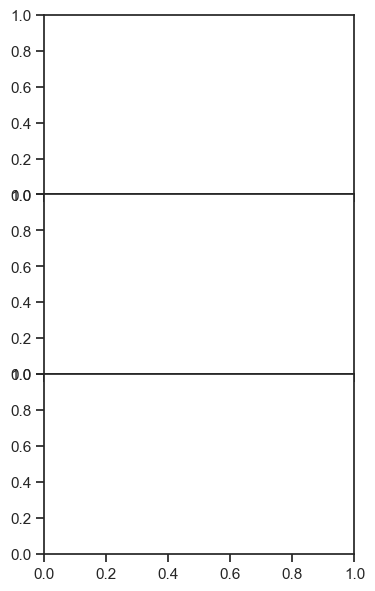

In [277]:
subplots(comm, depth, fids, 2, newseparated)

In [ ]:
save_individual_plots(comm,depth,fid,newseparated)

In [ ]:
save_all4_plots(comm,depth,fid,newseparated)

### Permanova results from R into boxplots

In [ ]:
permresu = pd.read_csv('R_results/post_hoc_results.csv')

In [ ]:
permresu["depth_pairs"] = permresu["depth"].astype(str) + permresu["pairs"]

In [ ]:
ax = sns.catplot(
    permresu, kind="bar",
    x="p.adjusted", y="pairs", col="comm", hue="depth",
    height=4, aspect=1.3, palette="Greys", log=True
)
#ax.set(xlim=(0, 0.10))

ax.refline(x=0.05, color='red')

plt.savefig('outputs/perm_pvalues_logged.png', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
ax = sns.catplot(
    permresu, kind="bar",
    x="p.adjusted", y="pairs", col="comm", hue="depth",
    height=4, aspect=1.3, palette="Greys", log=True
)
#ax.set(xlim=(0, 0.10))

ax.refline(x=0.05, color='red')

plt.savefig('outputs/perm_pvalues_logged.png', bbox_inches='tight', dpi=300)

plt.show()

## Random Forest

In [110]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

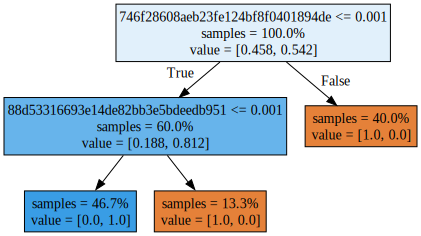

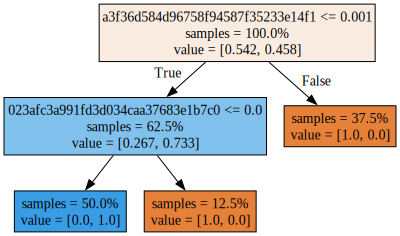

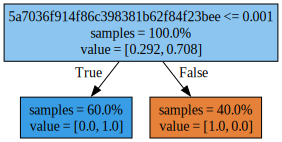

In [268]:
# Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [266]:
newsep2 = newseparated[newseparated.size_code != 'L']
newsep2 = newsep2[newsep2.size_code != 'S']

In [267]:
depth='E'
d_spc = newsep2[newsep2.depth_code== depth]

forrandomforest = d_spc[['feature_id', 'ratio', 'size_code','sampleid']]
forrandomforest.drop_duplicates(inplace=True)
RF = forrandomforest.pivot(index=['sampleid','size_code'],columns='feature_id', values='ratio').reset_index()
RF.drop(columns='sampleid', inplace=True)
RF = RF.fillna(0)

RF['size_code'] = RF['size_code'].map({'S':1,'W':2, 'SL':3, 'L':4})

# Split the data into features (X) and target (y)
X = RF.drop('size_code', axis=1)
y = RF['size_code']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [269]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist , n_iter=5, cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 7, 'n_estimators': 105}


In [270]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#ConfusionMatrixDisplay(confusion_matrix=cm).plot();

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'g__NS7_marine_group'),
  Text(1, 0, 'g__RS62_marine_group'),
  Text(2, 0, 'g__OM190'),
  Text(3, 0, 'g__uncultured'),
  Text(4, 0, 'g__PeM15'),
  Text(5, 0, 'Unassigned')])

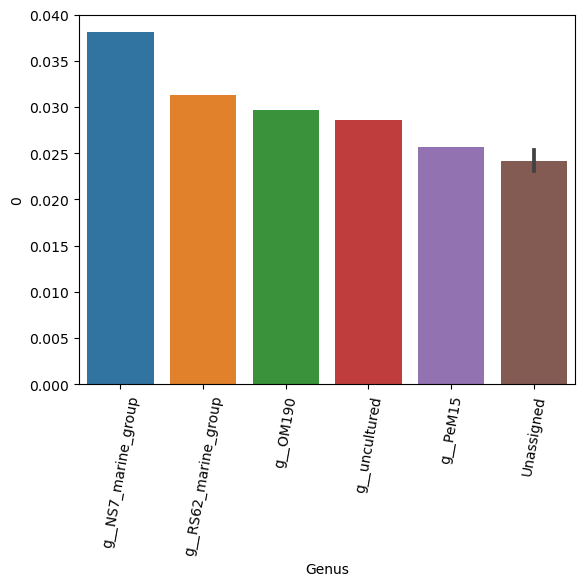

In [271]:
# Create a series contain feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_importances10 =feature_importances.head(7)
#add taxonomic id to important features
tax = newseparated[['feature_id','Taxon', 'Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']].copy()
tax.drop_duplicates(inplace=True)
new=feature_importances10.to_frame().reset_index()
new = new.merge(tax, how='left', on='feature_id')
new.to_csv('outputs/'+comm+'/top10predictors'+str(depth)+'.csv')

#visualize it
sns.barplot(
    data= new,
    x= 'Genus',
    y= 0)
plt.xticks(rotation=80)

In [205]:
f_id = '307176769bd6b53e2fab90260573b11e'
newseparated.loc[newseparated['feature_id'] == f_id, 'Taxon'].tolist()[0]

'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Crocinitomicaceae; g__Fluviicola; s__uncultured_Flavobacteriia'

<AxesSubplot: xlabel='weekn', ylabel='ratio'>

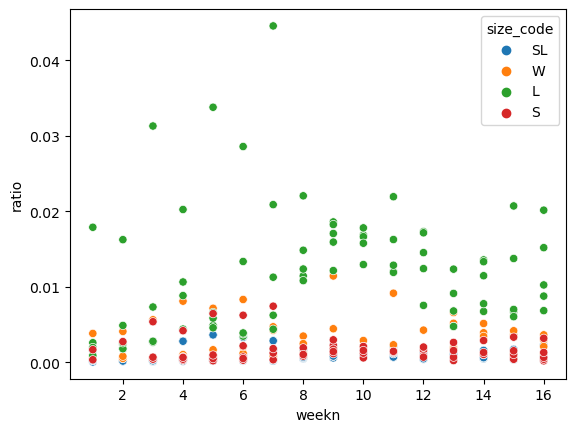

In [206]:
onlyher = newseparated.loc[newseparated['feature_id'] == f_id]
sns.scatterplot(x='weekn', y='ratio', hue='size_code',data=onlyher)